# Paper 2: Denoising Diffusion Probabilistic Models

In [6]:
from diffusion_model import DiffusionModel
from data_prep import sample_batch
from unet import UNet
import torch
from tqdm import tqdm

2023-07-24 11:39:18.846199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import matplotlib.pyplot as plt
import numpy as np

## Globals

In [8]:
# device = 'cuda'
device = 'cpu'
batch_size = 64


## Inspect data

In [9]:
sample = sample_batch(batch_size, device)
print(type(sample))
print(sample.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 32, 32])


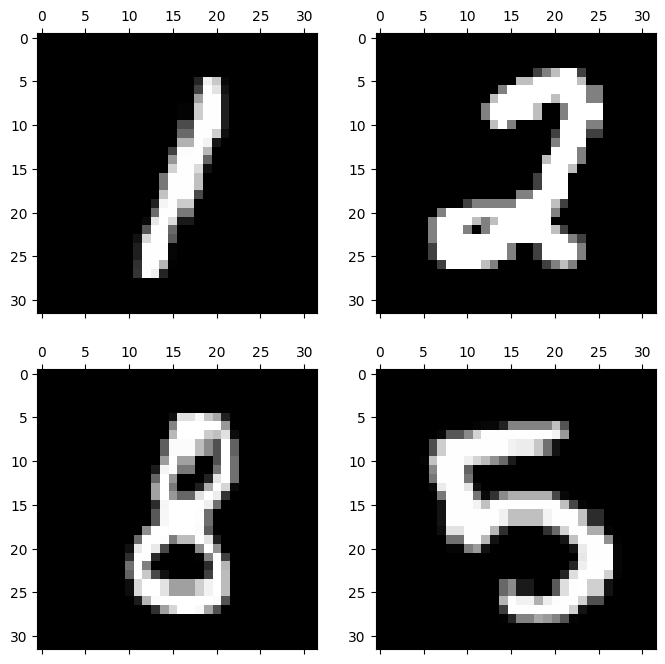

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes[0,0].matshow(sample[0,0], cmap='gray')
axes[0,1].matshow(sample[1,0], cmap='gray')
axes[1,0].matshow(sample[2,0], cmap='gray')
axes[1,1].matshow(sample[3,0], cmap='gray')

## Modelling

### Algorithm: Training

Repeat
* Sample image $x_0 \sim q(x_0)$
* Sample time step $t \sim \text{Uniform}(\{1, ..., T\})$
* Sample noise $\epsilon \sim N(0, I)$
* Take gradient step
  * Add noise $\epsilon$ to sample $x_0$. Where the noise is reparamized before
  * Let the UNet model predict the noise

until convergence

In [11]:
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)

In [ ]:
training_loss = []
for epoch in tqdm(range(40_000)):
    loss = diffusion_model.training(batch_size, optimizer)
    training_loss.append(loss)

    if epoch % 100 == 0:
        plt.plot(training_loss)
        plt.savefig('training_loss.png')
        plt.close()

        plt.plot(training_loss[-1000:])
        plt.savefig('training_loss_cropped.png')
        plt.close()

    if epoch % 5000 == 0:
        nb_images=81
        samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
        plt.figure(figsize=(17, 17))
        for i in range(nb_images):
            plt.subplot(9, 9, 1 + i)
            plt.axis('off')
            plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
        plt.savefig(f'samples_epoch_{epoch}.png')
        plt.close()

        torch.save(model.cpu(), f'model_paper2_epoch_{epoch}')
        model.cuda()

## Inference

### Algorithm: Sampling (Inference)

* Sample initial seed for the image $x_T \sim N(0, I)$
* for $t=T,...,1$ do
  * $z = \sim N(0,I) \text{ if } t>1, \text{ else } z=0$
  * Restore noise $ x_{t-1} = \mu_t + \sigma_t * z$
* end for
* return $x_0$

In [10]:
nb_images=81
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
plt.savefig(f'samples_epoch_{epoch}.png')
plt.close()

torch.save(model.cpu(), f'model_paper2_epoch_{epoch}')